## Wielomiany interpolujące

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sympy as sym
from sympy import latex
from sympy.printing import cxxcode

import re

from IPython.display import display, Latex

Używamy wielomianów trzeciego rzędu, które pozwalają na zagwarantowanie ciągłości funkcji i pochodnych.

In [2]:
Φ = np.linalg.inv(np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [1, 1, 1, 1],
    [0, 1, 2, 3]
])).T
for a in Φ:
    print("φ(ξ) = {:2g}ξ³{:+g}ξ²{:+g}ξ{:+g}".format(*reversed(a)))


φ(ξ) =  2ξ³-3ξ²+0ξ+1
φ(ξ) =  1ξ³-2ξ²+1ξ+0
φ(ξ) = -2ξ³+3ξ²+0ξ+0
φ(ξ) =  1ξ³-1ξ²+0ξ+0


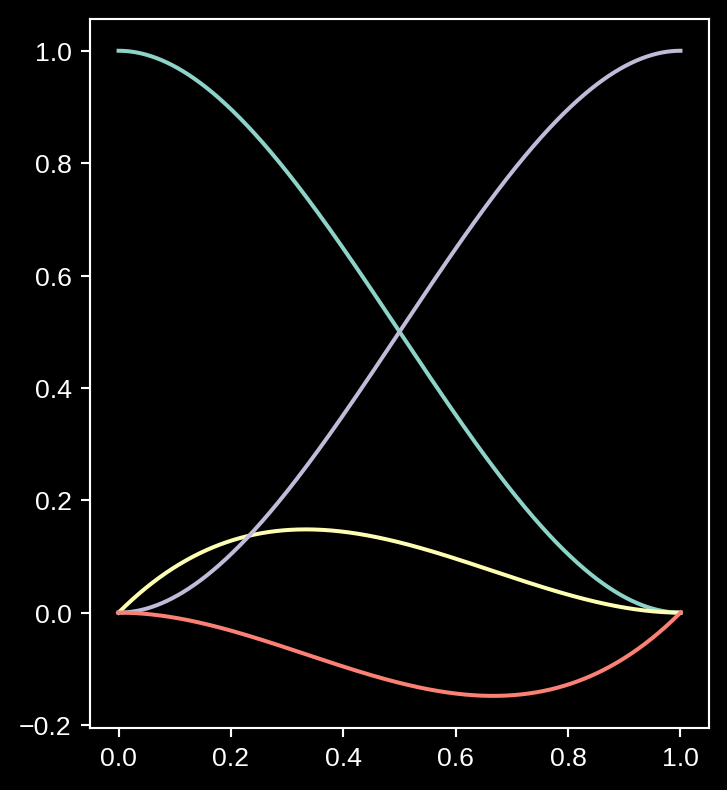

In [3]:
plt.axes(aspect='equal')
x = np.linspace(0, 1, 1001)
for p in Φ:
    y = sum(c * x**i for i,c in enumerate(p))
    plt.plot(x, y)
plt.show()

# Równanie dyfuzji nośników

Równanie do rozwiązania ma postać:
$$
D \Delta u - A u - B u^2 - C u^3 + J = 0,
$$
gdzie
$$
J = \frac{j_\perp}{q_e\,d},
$$
w którym $j_\perp$ to wstrzykiwana gęstość prądu a $d$ to grubość złącza. Po zamianie na równanie linowe (korzystając z rozwinięcia w szereg Taylora) mamy:
$$
D \Delta u - E u + F = 0,
$$
gdzie
\begin{align}
E & = A + 2 B u_0 + 3 C u_0^2 \\
F & = B u_0^2 + 2 C u_0^3 + J_0
\end{align}

In [4]:
A, B, C, D, L = sym.symbols('A B C D L')


Zastosujmy metodę Ritza w we współrzędnych kartezjańskich i biegunowych.

In [5]:
x, r, R = sym.symbols('x r R')

ξ = x / L

r1 = R - L / 2
r2 = R + L / 2
ξr = (r - r1) / (r2 - r1)

Funkcje próbne mają postać:

In [6]:
φ = [sum(int(c) * ξ**i for i,c in enumerate(p)) for p in Φ]
φ[1] *= L
φ[3] *= L
φ = np.array([sym.expand(a) for a in φ])
dφ = np.array([sym.expand(sym.diff(a, x)) for a in φ])

In [7]:
display(Latex("\\begin{align}\n" +
    ' \\\\\n'.join(f'\\varphi_{i}(x) & = {latex(p)}' for i,p in enumerate(φ))
    + "\n\\end{align}\n"))


<IPython.core.display.Latex object>

A ich pochodne:

In [8]:
display(Latex("\\begin{align}\n" +
    ' \\\\\n'.join(f'\\frac{{d\\varphi_{i}}}{{dx}} & = {latex(p)}' for i,p in enumerate(dφ))
    + "\n\\end{align}\n"))


<IPython.core.display.Latex object>

## Funkcja przybliżana

Zakładamy, że
$$
u(\xi) = \sum_i u^i \, \varphi_i(\xi) \qquad u_0(\xi) = \sum_i a^i \,\varphi_i(\xi)
$$
gdzie
\begin{align}
u^1, u^2, u^3, u^4 & = u(0), \left.\tfrac{du}{dx}\right|_0, u(L), \left.\tfrac{du}{dx}\right|_L \\
a^1, a^2, a^3, a^4 & = u_0(0), \left.\tfrac{du_0}{dx}\right|_0, u_0(L), \left.\tfrac{du_0}{dx}\right|_L
\end{align}

In [9]:
u = sym.IndexedBase('u', shape=(4,))
a = sym.IndexedBase('a', shape=(4,))

In [10]:
u0 = sum(a[k] * φ[k] for k in range(4))
u0

(3*x**2/L**2 - 2*x**3/L**3)*a[2] + (-x**2/L + x**3/L**2)*a[3] + (1 - 3*x**2/L**2 + 2*x**3/L**3)*a[0] + (x - 2*x**2/L + x**3/L**2)*a[1]

## Interpolacja Czebyszewa dla prądu

Aby dobrze odzdwierciedlić rozpływ prądu, korzystamy z interpolacji Czebyszewa. Zachodzi ona na punktach

In [11]:
z = L * (1 - np.cos((2*np.arange(1,5)-1)/8 * np.pi)) / 2
sym.Array(z)

[0.0380602337443566*L, 0.308658283817455*L, 0.691341716182545*L, 0.961939766255643*L]

a we współrzędnych biegunowych

In [12]:
zr = z + r1
sym.Array(zr)

[-0.461939766255643*L + R, -0.191341716182545*L + R, 0.191341716182545*L + R, 0.461939766255643*L + R]

Teraz zakładmy, że w tych punktach mamy wartości funkcji $J$. Budujemy wielomiany interpolacyjne.

In [13]:
J = sym.IndexedBase('J', shape=(4,))

def La(i, x, z):
    res = 1
    for j in range(4):
        if j == i: continue
        res *= (x - z[j]) / (z[i] - z[j])
    return res

In [14]:
Jx = sym.simplify(sum(J[i] * La(i, x, z) for i in range(4)))
Jx

(-6.12293491784144*(0.0380602337443566*L - x)*(0.308658283817455*L - x)*(0.691341716182545*L - x)*J[3] + 14.7820725201806*(0.0380602337443566*L - x)*(0.308658283817455*L - x)*(0.961939766255643*L - x)*J[2] - 14.7820725201806*(0.0380602337443566*L - x)*(0.691341716182545*L - x)*(0.961939766255643*L - x)*J[1] + 6.12293491784144*(0.308658283817455*L - x)*(0.691341716182545*L - x)*(0.961939766255643*L - x)*J[0])/L**3

In [15]:
Jr = sym.simplify(sum(J[i] * La(i, r, zr) for i in range(4)))
Jr

(-6.12293491784144*(0.191341716182545*L + R - r)*(0.191341716182545*L - R + r)*(0.461939766255643*L - R + r)*J[3] - 6.12293491784144*(0.191341716182545*L + R - r)*(0.191341716182545*L - R + r)*(0.461939766255643*L + R - r)*J[0] + 14.7820725201806*(0.191341716182545*L + R - r)*(0.461939766255643*L - R + r)*(0.461939766255643*L + R - r)*J[1] + 14.7820725201806*(0.191341716182545*L - R + r)*(0.461939766255643*L - R + r)*(0.461939766255643*L + R - r)*J[2])/L**3

# Macierze sztywności i wektor obciążeń

In [16]:
ii, jj  = np.meshgrid(range(4), range(4))
i_ = np.arange(4)

## Kartezjańsko


Macierz sztywności budujemy z równania
$$
\left( - D \frac{d^2}{dx^2} + A + 2 B u_0 + 3 C u_0^2 \right) u = B u_0^2 + 2 C u_0^3 + J_0.
$$
Pamiętając, że
$$
u(\xi) = \sum_i u^i \, \varphi_i(x)
$$
i stosując metodę Ritza mamy
$$
\sum_j \int_0^L \left[ D \frac{d\varphi_i}{dx} \frac{d\varphi_j}{dx} + \left( A + 2 B u_0 + 3 C u_0^2 \right) \varphi_i \varphi_j \right] u^j = \left( B u_0^2 + 2 C u_0^3 + J_0 \right) \varphi_i.
$$

Do tego, stosując
$$
u_0(\xi) = \sum_i a^i \,\varphi_i(x)
$$
Mamy

In [17]:
KD = sym.simplify(sym.integrate(sym.Matrix(D * dφ[ii] * dφ[jj]), (x, 0, L)))
KA = sym.simplify(sym.integrate(sym.Matrix(A * φ[ii] * φ[jj]), (x, 0, L)))
KB = sym.simplify(sym.integrate(sym.Matrix(2 * B * u0 * φ[ii] * φ[jj]), (x, 0, L)))
KC = sym.simplify(sym.integrate(sym.Matrix(3 * C * u0**2 * φ[ii] * φ[jj]), (x, 0, L)))
K = KD + KA + KB + KC
K

Matrix([
[  13*A*L/35 + B*L*(97*L*a[1] - 43*L*a[3] + 774*a[0] + 162*a[2])/1260 + C*L*(840*L**2*a[1]**2 - 777*L**2*a[1]*a[3] + 268*L**2*a[3]**2 + 11004*L*a[0]*a[1] - 4011*L*a[0]*a[3] + 2867*L*a[1]*a[2] - 2138*L*a[2]*a[3] + 48132*a[0]**2 + 14418*a[0]*a[2] + 4374*a[2]**2)/60060 + 6*D/(5*L), 11*A*L**2/210 + B*L**2*(16*L*a[1] - 9*L*a[3] + 97*a[0] + 35*a[2])/1260 + C*L**2*(294*L**2*a[1]**2 - 322*L**2*a[1]*a[3] + 125*L**2*a[3]**2 + 3360*L*a[0]*a[1] - 1554*L*a[0]*a[3] + 1216*L*a[1]*a[2] - 1020*L*a[2]*a[3] + 11004*a[0]**2 + 5734*a[0]*a[2] + 2138*a[2]**2)/120120 + D/10,         9*A*L/70 + B*L*(35*L*a[1] - 35*L*a[3] + 162*a[0] + 162*a[2])/1260 + C*L*(304*L**2*a[1]**2 - 510*L**2*a[1]*a[3] + 304*L**2*a[3]**2 + 2867*L*a[0]*a[1] - 2138*L*a[0]*a[3] + 2138*L*a[1]*a[2] - 2867*L*a[2]*a[3] + 7209*a[0]**2 + 8748*a[0]*a[2] + 7209*a[2]**2)/60060 - 6*D/(5*L),   -13*A*L**2/420 + B*L**2*(-9*L*a[1] + 8*L*a[3] - 43*a[0] - 35*a[2])/1260 + C*L**2*(-161*L**2*a[1]**2 + 250*L**2*a[1]*a[3] - 135*L**2*a[3]**2 - 1554*L*a

In [18]:
FB = sym.simplify(sym.integrate(sym.Matrix(B * u0**2 * φ[i_]), (x, 0, L)))
FC = sym.simplify(sym.integrate(sym.Matrix(2 * C * u0**3 * φ[i_]), (x, 0, L)))
F0 = sym.simplify(sym.integrate(sym.Matrix(Jx * φ[i_]), (x, 0, L)))
F = FB + FC + F0
F

Matrix([
[        B*L*(8*L**2*a[1]**2 - 9*L**2*a[1]*a[3] + 4*L**2*a[3]**2 + 97*L*a[0]*a[1] - 43*L*a[0]*a[3] + 35*L*a[1]*a[2] - 35*L*a[2]*a[3] + 387*a[0]**2 + 162*a[0]*a[2] + 81*a[2]**2)/1260 + C*L*(98*L**3*a[1]**3 - 161*L**3*a[1]**2*a[3] + 125*L**3*a[1]*a[3]**2 - 45*L**3*a[3]**3 + 1680*L**2*a[0]*a[1]**2 - 1554*L**2*a[0]*a[1]*a[3] + 536*L**2*a[0]*a[3]**2 + 608*L**2*a[1]**2*a[2] - 1020*L**2*a[1]*a[2]*a[3] + 608*L**2*a[2]*a[3]**2 + 11004*L*a[0]**2*a[1] - 4011*L*a[0]**2*a[3] + 5734*L*a[0]*a[1]*a[2] - 4276*L*a[0]*a[2]*a[3] + 2138*L*a[1]*a[2]**2 - 2867*L*a[2]**2*a[3] + 32088*a[0]**3 + 14418*a[0]**2*a[2] + 8748*a[0]*a[2]**2 + 4806*a[2]**3)/60060 + L*(0.131127857269028*J[0] + 0.288185303514769*J[1] + 0.0796658266829926*J[2] + 0.00102101253321329*J[3])],
[  B*L**2*(3*L**2*a[1]**2 - 4*L**2*a[1]*a[3] + 2*L**2*a[3]**2 + 32*L*a[0]*a[1] - 18*L*a[0]*a[3] + 16*L*a[1]*a[2] - 18*L*a[2]*a[3] + 97*a[0]**2 + 70*a[0]*a[2] + 43*a[2]**2)/2520 + C*L**2*(56*L**3*a[1]**3 - 105*L**3*a[1]**2*a[3] + 90*L**3*a[1]*a[

In [19]:
def cpp(v):
    s = cxxcode(v, standard='C++11')
    #for i in range(1, 5):
    #    s = s.replace(f"a[{i}]", f"a{i}")
    s = re.sub(r'std::pow\(L, (\d+)\)', r'L\1', s)
    s = re.sub(r'std::pow\(([^)]+), (\d+)\)', r'std::pow(\1,\2)', s)
    s = re.sub(r'std::pow\(([^)]+),2\)', r'\1*\1', s)
    s = re.sub(r'std::pow\(([^)]+),3\)', r'\1*\1*\1', s)
    return s.replace('_', '')

In [20]:
for i in range(4):
    for j in range(i, 4):
        print(f"double K{i}{j} = {cpp(K[i,j])};\n")
for i in range(4):
    print(f"double F{i} = {cpp(F[i])};\n")

double K00 = (13.0/35.0)*A*L + (1.0/1260.0)*B*L*(97*L*a[1] - 43*L*a[3] + 774*a[0] + 162*a[2]) + (1.0/60060.0)*C*L*(840*L2*a[1]*a[1] - 777*L2*a[1]*a[3] + 268*L2*a[3]*a[3] + 11004*L*a[0]*a[1] - 4011*L*a[0]*a[3] + 2867*L*a[1]*a[2] - 2138*L*a[2]*a[3] + 48132*a[0]*a[0] + 14418*a[0]*a[2] + 4374*a[2]*a[2]) + (6.0/5.0)*D/L;

double K01 = (11.0/210.0)*A*L2 + (1.0/1260.0)*B*L2*(16*L*a[1] - 9*L*a[3] + 97*a[0] + 35*a[2]) + (1.0/120120.0)*C*L2*(294*L2*a[1]*a[1] - 322*L2*a[1]*a[3] + 125*L2*a[3]*a[3] + 3360*L*a[0]*a[1] - 1554*L*a[0]*a[3] + 1216*L*a[1]*a[2] - 1020*L*a[2]*a[3] + 11004*a[0]*a[0] + 5734*a[0]*a[2] + 2138*a[2]*a[2]) + (1.0/10.0)*D;

double K02 = (9.0/70.0)*A*L + (1.0/1260.0)*B*L*(35*L*a[1] - 35*L*a[3] + 162*a[0] + 162*a[2]) + (1.0/60060.0)*C*L*(304*L2*a[1]*a[1] - 510*L2*a[1]*a[3] + 304*L2*a[3]*a[3] + 2867*L*a[0]*a[1] - 2138*L*a[0]*a[3] + 2138*L*a[1]*a[2] - 2867*L*a[2]*a[3] + 7209*a[0]*a[0] + 8748*a[0]*a[2] + 7209*a[2]*a[2]) - 6.0/5.0*D/L;

double K03 = -13.0/420.0*A*L2 + (1.0/1260.0)*B*L2*

## Cylindrycznie

In [21]:
φr = [sum(int(c) * ξr**i for i,c in enumerate(p)) for p in Φ]
φr[1] *= (r2 - r1)
φr[3] *= (r2 - r1)
φr = np.array([sym.simplify(a) for a in φr])
dφr = np.array([sym.simplify(sym.diff(a, r)) for a in φr])

In [22]:
display(Latex("\\begin{align}\n" +
    ' \\\\\n'.join(f'\\varphi_{i+1}(r) & = {latex(p)}' for i,p in enumerate(φr))
    + "\n\\end{align}\n"))


<IPython.core.display.Latex object>

In [23]:
display(Latex("\\begin{align}\n" +
    ' \\\\\n'.join(f'\\frac{{d\\varphi_{i+1}}}{{dr}} & = {latex(p)}' for i,p in enumerate(dφr))
    + "\n\\end{align}\n"))

<IPython.core.display.Latex object>

In [24]:
u0r = sum(a[k] * φr[k] for k in range(4))
u0r

(-L - 2*R + 2*r)*(L - 2*R + 2*r)**2*a[3]/(8*L**2) + (L - 2*R + 2*r)*(4*L**2 - 4*L*(L - 2*R + 2*r) + (L - 2*R + 2*r)**2)*a[1]/(8*L**2) + (L - 2*R + 2*r)**2*(L + R - r)*a[2]/(2*L**3) + (4*L**3 - 3*L*(L - 2*R + 2*r)**2 + (L - 2*R + 2*r)**3)*a[0]/(4*L**3)

In [25]:
KrD = sym.simplify(sym.integrate(sym.Matrix(r * D * dφr[ii] * dφr[jj]), (r, r1, r2)))
KrA = sym.simplify(sym.integrate(sym.Matrix(r * A * φr[ii] * φr[jj]), (r, r1, r2)))
KrB = sym.simplify(sym.integrate(sym.Matrix(r * 2 * B * u0r * φr[ii] * φr[jj]), (r, r1, r2)))
KrC = sym.simplify(sym.integrate(sym.Matrix(r * 3 * C * u0r**2 * φr[ii] * φr[jj]), (r, r1, r2)))
Kr = KrD + KrA + KrB + KrC
Kr = R * sym.simplify(sym.expand(Kr/R))
Kr

Matrix([
[                                                                                                          (432432*D*R + L**3*(-36036*A - 6331*B*L*a[1] + 1391*B*L*a[3] - 67860*B*a[0] - 4212*B*a[2] - 1062*C*L**2*a[1]**2 + 585*C*L**2*a[1]*a[3] - 69*C*L**2*a[3]**2 - 17100*C*L*a[0]*a[1] + 3879*C*L*a[0]*a[3] - 1893*C*L*a[1]*a[2] + 294*C*L*a[2]*a[3] - 95472*C*a[0]**2 - 12636*C*a[0]*a[2]) + 2*L**2*R*(66924*A + 13871*B*L*a[1] - 6149*B*L*a[3] + 110682*B*a[0] + 23166*B*a[2] + 2520*C*L**2*a[1]**2 - 2331*C*L**2*a[1]*a[3] + 804*C*L**2*a[3]**2 + 33012*C*L*a[0]*a[1] - 12033*C*L*a[0]*a[3] + 8601*C*L*a[1]*a[2] - 6414*C*L*a[2]*a[3] + 144396*C*a[0]**2 + 43254*C*a[0]*a[2] + 13122*C*a[2]**2))/(360360*L), -A*L**3/105 - 31*B*L**4*a[1]/13860 + B*L**4*a[3]/1848 - 487*B*L**3*a[0]/27720 - 41*B*L**3*a[2]/27720 - 17*C*L**5*a[1]**2/40040 + 31*C*L**5*a[1]*a[3]/120120 - C*L**5*a[3]**2/48048 - 59*C*L**4*a[0]*a[1]/10010 + C*L**4*a[0]*a[3]/616 - 7*C*L**4*a[1]*a[2]/8580 - 95*C*L**3*a[0]**2/4004 - 631*C*L**3*a[0]

In [26]:
FrB = sym.simplify(sym.integrate(sym.Matrix(r * B * u0r**2 * φr[i_]), (r, r1, r2)))
FrC = sym.simplify(sym.integrate(sym.Matrix(r * 2 * C * u0r**3 * φr[i_]), (r, r1, r2)))
Fr0 = sym.simplify(sym.integrate(sym.Matrix(r * Jr * φr[i_]), (r, r1, r2)))
Fr = FB + FC + F0
Fr = R * sym.simplify(sym.expand(Fr/R))
Fr

Matrix([
[L*(1144*B*L**2*a[1]**2 - 1287*B*L**2*a[1]*a[3] + 572*B*L**2*a[3]**2 + 13871*B*L*a[0]*a[1] - 6149*B*L*a[0]*a[3] + 5005*B*L*a[1]*a[2] - 5005*B*L*a[2]*a[3] + 55341*B*a[0]**2 + 23166*B*a[0]*a[2] + 11583*B*a[2]**2 + 294*C*L**3*a[1]**3 - 483*C*L**3*a[1]**2*a[3] + 375*C*L**3*a[1]*a[3]**2 - 135*C*L**3*a[3]**3 + 5040*C*L**2*a[0]*a[1]**2 - 4662*C*L**2*a[0]*a[1]*a[3] + 1608*C*L**2*a[0]*a[3]**2 + 1824*C*L**2*a[1]**2*a[2] - 3060*C*L**2*a[1]*a[2]*a[3] + 1824*C*L**2*a[2]*a[3]**2 + 33012*C*L*a[0]**2*a[1] - 12033*C*L*a[0]**2*a[3] + 17202*C*L*a[0]*a[1]*a[2] - 12828*C*L*a[0]*a[2]*a[3] + 6414*C*L*a[1]*a[2]**2 - 8601*C*L*a[2]**2*a[3] + 96264*C*a[0]**3 + 43254*C*a[0]**2*a[2] + 26244*C*a[0]*a[2]**2 + 14418*C*a[2]**3 + 23626.6173227335*J[0] + 51925.2279872911*J[1] + 14354.1886517416*J[2] + 183.966038234371*J[3])/180180],
[         L**2*(429*B*L**2*a[1]**2 - 572*B*L**2*a[1]*a[3] + 286*B*L**2*a[3]**2 + 4576*B*L*a[0]*a[1] - 2574*B*L*a[0]*a[3] + 2288*B*L*a[1]*a[2] - 2574*B*L*a[2]*a[3] + 13871*B*a[0]**2 

In [27]:
for i in range(4):
    for j in range(i, 4):
        print(f"double K{i}{j} = {cpp(Kr[i,j])};\n")
for i in range(4):
    print(f"double F{i} = {cpp(Fr[i])};\n")

double K00 = (1.0/360360.0)*(432432*D*R + L3*(-36036*A - 6331*B*L*a[1] + 1391*B*L*a[3] - 67860*B*a[0] - 4212*B*a[2] - 1062*C*L2*a[1]*a[1] + 585*C*L2*a[1]*a[3] - 69*C*L2*a[3]*a[3] - 17100*C*L*a[0]*a[1] + 3879*C*L*a[0]*a[3] - 1893*C*L*a[1]*a[2] + 294*C*L*a[2]*a[3] - 95472*C*a[0]*a[0] - 12636*C*a[0]*a[2]) + 2*L2*R*(66924*A + 13871*B*L*a[1] - 6149*B*L*a[3] + 110682*B*a[0] + 23166*B*a[2] + 2520*C*L2*a[1]*a[1] - 2331*C*L2*a[1]*a[3] + 804*C*L2*a[3]*a[3] + 33012*C*L*a[0]*a[1] - 12033*C*L*a[0]*a[3] + 8601*C*L*a[1]*a[2] - 6414*C*L*a[2]*a[3] + 144396*C*a[0]*a[0] + 43254*C*a[0]*a[2] + 13122*C*a[2]*a[2]))/L;

double K01 = -1.0/105.0*A*L3 - 31.0/13860.0*B*L4*a[1] + (1.0/1848.0)*B*L4*a[3] - 487.0/27720.0*B*L3*a[0] - 41.0/27720.0*B*L3*a[2] - 17.0/40040.0*C*L5*a[1]*a[1] + (31.0/120120.0)*C*L5*a[1]*a[3] - 1.0/48048.0*C*L5*a[3]*a[3] - 59.0/10010.0*C*L4*a[0]*a[1] + (1.0/616.0)*C*L4*a[0]*a[3] - 7.0/8580.0*C*L4*a[1]*a[2] - 95.0/4004.0*C*L3*a[0]*a[0] - 631.0/120120.0*C*L3*a[0]*a[2] + (7.0/17160.0)*C*L3*a[2]*